In [46]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
from pybaseball import pitching_stats, batting_stats

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import explained_variance_score
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

##### Data download
Code below was is in a raw cell so it won't execute as it can take some time to execute. It is left here for reference. In subsequent sessions, the data was read via a saved CSV.

In [2]:
# Load the data
all_hit = pd.read_csv(f'all_hit_data.csv')

Check distribution of some variables

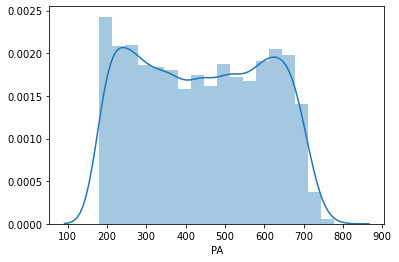

In [4]:
sns.distplot(all_hit['PA'])

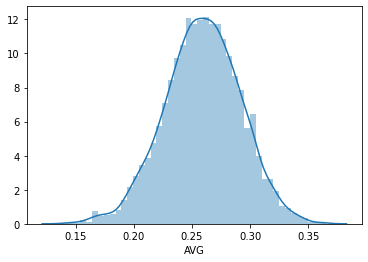

In [6]:
sns.distplot(all_hit['AVG'])

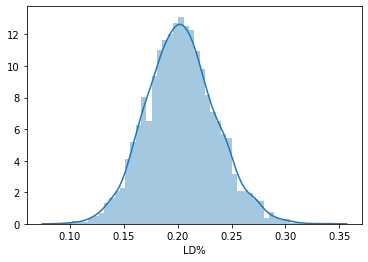

In [7]:
sns.distplot(all_hit['LD%'])

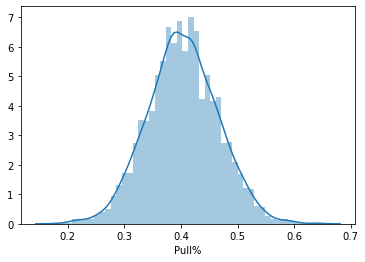

In [9]:
sns.distplot(all_hit['Pull%'])

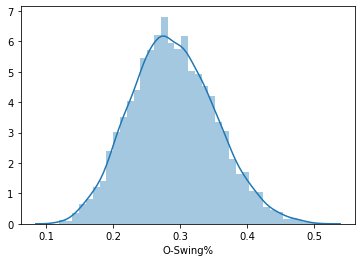

In [10]:
sns.distplot(all_hit['O-Swing%'])

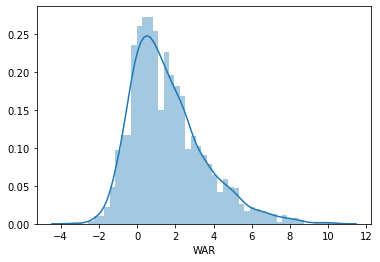

In [12]:
sns.distplot(all_hit['WAR'])

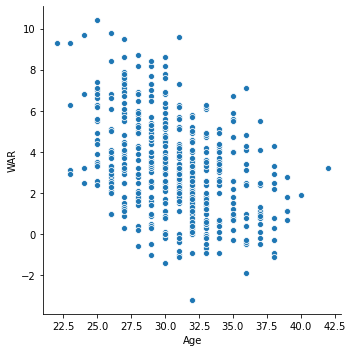

In [11]:
sns.relplot(x='Age',y='WAR',data=all_hit[all_hit['WAR_3']>4])

In [16]:
# This removes current season data except age and WAR and only leaves pivoted previous season
# WAR for current season will be chopped off into the target variable
model_data = all_hit.filter(regex='(^Age$)|(^WAR$)|(^Season$)|(_\d$)', axis=1)

In [17]:
# split train/test
# seasons before 2019
X_train = model_data[model_data['Season']<2019][['Age','AB_3','AVG_3','BABIP_3','BB%_3','BB/K_3','Contact%_3','FB%_3','G_3',
'GB%_3','GDP_3','H_3','HBP_3','HR_3','HR/FB_3','Hard%_3','IFFB%_3','ISO_3',
'K%_3','LD%_3','OPS_3','PA_3','R_3','RAR_3','RBI_3','SB_3','SF_3','SH_3',
'SO_3','WAR_3','wOBA_3','wRAA_3','wRC_3','AB_2','AVG_2','BABIP_2','BB%_2',
'BB/K_2','Contact%_2','FB%_2','G_2','GB%_2','GDP_2','H_2','HBP_2','HR_2',
'HR/FB_2','Hard%_2','IFFB%_2','ISO_2','K%_2','LD%_2','OPS_2','PA_2','R_2',
'RAR_2','RBI_2','SB_2','SF_2','SH_2','SO_2','WAR_2','wOBA_2','wRAA_2','wRC_2',
'AB_1','AVG_1','BABIP_1','BB%_1','BB/K_1','Contact%_1','FB%_1','G_1','GB%_1',
'GDP_1','H_1','HBP_1','HR_1','HR/FB_1','Hard%_1','IFFB%_1','ISO_1','K%_1',
'LD%_1','OPS_1','PA_1','R_1','RAR_1','RBI_1','SB_1','SF_1','SH_1','SO_1',
'WAR_1','wOBA_1','wRAA_1','wRC_1']]

# 2019 season
X_test = model_data[model_data['Season']==2019][['Age','AB_3','AVG_3','BABIP_3','BB%_3','BB/K_3','Contact%_3','FB%_3','G_3',
'GB%_3','GDP_3','H_3','HBP_3','HR_3','HR/FB_3','Hard%_3','IFFB%_3','ISO_3',
'K%_3','LD%_3','OPS_3','PA_3','R_3','RAR_3','RBI_3','SB_3','SF_3','SH_3',
'SO_3','WAR_3','wOBA_3','wRAA_3','wRC_3','AB_2','AVG_2','BABIP_2','BB%_2',
'BB/K_2','Contact%_2','FB%_2','G_2','GB%_2','GDP_2','H_2','HBP_2','HR_2',
'HR/FB_2','Hard%_2','IFFB%_2','ISO_2','K%_2','LD%_2','OPS_2','PA_2','R_2',
'RAR_2','RBI_2','SB_2','SF_2','SH_2','SO_2','WAR_2','wOBA_2','wRAA_2','wRC_2',
'AB_1','AVG_1','BABIP_1','BB%_1','BB/K_1','Contact%_1','FB%_1','G_1','GB%_1',
'GDP_1','H_1','HBP_1','HR_1','HR/FB_1','Hard%_1','IFFB%_1','ISO_1','K%_1',
'LD%_1','OPS_1','PA_1','R_1','RAR_1','RBI_1','SB_1','SF_1','SH_1','SO_1',
'WAR_1','wOBA_1','wRAA_1','wRC_1']]

In [74]:
# grab target variable
Y_train = model_data[model_data['Season']<2019]['WAR']
Y_test = model_data[model_data['Season']==2019]['WAR']

In [18]:
model_data[['WAR','WAR_3','WAR_2','WAR_1']].describe()

,WAR,WAR_3,WAR_2,WAR_1
count,4798.000000,2748.000000,3189.000000,3712.000000
mean,1.597124,2.293013,2.153669,1.979445
std,1.929800,2.035825,1.966809,1.939724
min,-3.400000,-3.400000,-3.400000,-3.400000
25%,0.200000,0.800000,0.700000,0.600000
50%,1.200000,2.000000,1.900000,1.700000
75%,2.600000,3.500000,3.300000,3.000000
max,10.400000,11.900000,10.200000,10.400000


### Select Features
Run through a process to see what my best features are

In [20]:
# create selector
selector = SelectKBest(score_func=f_classif, k=10)

In [23]:
# impute data
X_train['WAR_1'].fillna(1,inplace=True)
X_train['WAR_2'].fillna(1,inplace=True)
X_train['WAR_3'].fillna(1,inplace=True)
imputeTrain = SimpleImputer(strategy='median')
X_train_imputed = imputeTrain.fit_transform(X_train)

In [28]:
fit = selector.fit(X_train_imputed, Y_train)

In [29]:
features = fit.transform(X_train_imputed)

In [30]:
# Get columns that relate to best features
cols = fit.get_support(indices=True)
features_df_new = X_train.iloc[:,cols]
features_df_new.describe()

,RAR_3,WAR_3,RAR_2,WAR_2,OPS_1,R_1,RAR_1,WAR_1,wRAA_1,wRC_1
count,2549.000000,4417.000000,2952.000000,4417.000000,3432.000000,3432.000000,3432.000000,4417.000000,3432.000000,3432.000000
mean,22.369969,1.743491,20.927846,1.768859,0.762582,59.082459,19.323864,1.764388,5.933625,61.792832
std,19.948966,1.672853,19.260814,1.704588,0.096605,25.037062,18.929610,1.760453,15.307454,28.446495
min,-33.700000,-3.400000,-33.700000,-3.400000,0.382000,6.000000,-33.700000,-3.400000,-33.600000,-1.000000
25%,7.700000,1.000000,6.900000,1.000000,0.698000,39.000000,5.600000,0.900000,-4.500000,39.000000
50%,19.200000,1.000000,18.300000,1.000000,0.757000,57.000000,16.200000,1.000000,3.400000,59.000000
75%,33.900000,2.300000,31.900000,2.500000,0.822250,78.000000,29.900000,2.600000,13.725000,82.000000
max,122.100000,11.900000,98.200000,10.200000,1.114000,143.000000,98.200000,10.200000,77.300000,155.000000


#### Test a pipeline & gridsearch

In [31]:
# We've hardcoded values for the WAR_# statistics, but there may be some other values that need imputed
# So add scaler and imputer to pipeline
pipe = Pipeline([('impute', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('svr',SVR())
                ])

In [32]:
# set parameters to search
params = {'svr__C': [0.1, 1, 10],
          'svr__kernel': ['linear','rbf'],
          'svr__epsilon': [0.001, 0.01, 0.1]
         }

In [33]:
# build a search
grid = GridSearchCV(pipe,
                       param_grid=params,
                       scoring={'r2': make_scorer(r2_score)},
                       n_jobs=-1,
                       cv=5,
                       refit='r2')

In [34]:
# run grid search
grid.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.1, 1, 10],
                         'svr__epsilon': [0.001, 0.01, 0.1],
                         'svr__kernel': ['linear', 'rbf']},
             refit='r2', scoring={'r2': make_scorer(r2_score)})

In [35]:
grid.best_params_

{'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__kernel': 'linear'}

In [36]:
grid.best_score_

0.2634992602046511

In [37]:
# Create model based on best
svr_model = Pipeline([('impute', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()),
                 ('svr',SVR(C=0.1,epsilon=0.1,kernel='linear'))
                ])

In [41]:
# test scaling target
# create target scaler object
target_scaler = MinMaxScaler()

# reshape values for scaler and fit
target_scaler.fit(Y_train.values.reshape(-1,1))

# transform target
Y_train_trans = target_scaler.transform(Y_train.values.reshape(-1,1))

In [42]:
# preview values using ravel
Y_train_trans.ravel()

array([0.94202899, 0.85507246, 0.82608696, ..., 0.15217391, 0.12318841,
       0.01449275])

In [43]:
# Refit model with scaled data
svr_model.fit(X_train,Y_train_trans.ravel())

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('svr', SVR(C=0.1, kernel='linear'))])

In [44]:
# get predictions
y_pred = svr_model.predict(X_train)

In [45]:
# get score w/ scaled values
r2_score(Y_train_trans,y_pred)

0.3420593864391033

In [47]:
# try different scorer
explained_variance_score(Y_train_trans,y_pred)

0.3420958855165094

In [48]:
# look at a different model, no grid search
baymod = linear_model.BayesianRidge()

In [50]:
# remember we have imputed values in our data, which this model requires.
# fit on unscaled target
baymod.fit(X_train_imputed,Y_train)

BayesianRidge()

In [51]:
# get predictions
bay_y_pred = baymod.predict(X_train_imputed)

In [52]:
# score the model
r2_score(Y_train,bay_y_pred)

0.31518158996619605

In [55]:
# re-fit model with scaled data
baymod2 = linear_model.BayesianRidge()
baymod2.fit(X_train_imputed,Y_train_trans.ravel())

BayesianRidge()

In [59]:
bay2_y_pred = baymod2.predict(X_train_imputed)

In [60]:
r2_score(Y_train_trans.ravel(),bay2_y_pred)

0.3154423814395101

In [61]:
# try a final model, again w/o gridsearch
regr = MLPRegressor(random_state=1, max_iter=50000)

In [62]:
regr.fit(X_train_imputed, Y_train)

MLPRegressor(max_iter=50000, random_state=1)

In [63]:
nnreg_pred = regr.predict(X_train_imputed)

In [64]:
r2_score(Y_train,nnreg_pred)

0.02126323930401941

In [66]:
# Redo again, with scaled targets again
regr2 = MLPRegressor(random_state=1, max_iter=50000)
regr2.fit(X_train_imputed, Y_train_trans.ravel())
nnreg_pred2 = regr2.predict(X_train_imputed)

In [68]:
r2_score(Y_train_trans.ravel(),nnreg_pred2)

-24.546357344880345

In [77]:
## Run my best model against test data

# imput war_# values. others will be imputed by pipeline
X_test['WAR_1'].fillna(1,inplace=True)
X_test['WAR_2'].fillna(1,inplace=True)
X_test['WAR_3'].fillna(1,inplace=True)

# pipeline did not include scaling target, so do that now
test_target_scaler = MinMaxScaler()

# reshape values for scaler and fit
test_target_scaler.fit(Y_test.values.reshape(-1,1))

# transform target
Y_test_trans = test_target_scaler.transform(Y_test.values.reshape(-1,1))



In [78]:
# predict against test set
test_preds = svr_model.predict(X_test)

In [80]:
# score model against test set
r2_score(Y_test_trans,test_preds)

0.307518259681842

### Explore Why Models aren't so good

In [70]:
all_hit[all_hit['Name']=='Chris Davis'][['Season','WAR']]

,Season,WAR
579,2008.0,0.8
1058,2009.0,-0.5
1782,2011.0,-0.5
1976,2012.0,1.8
2208,2013.0,7.1
2780,2014.0,0.9
2953,2015.0,5.4
3382,2016.0,2.9
3971,2017.0,0.0
4416,2018.0,-3.2


In [71]:
all_hit[all_hit['Name']=='Mike Trout'][['Season','WAR']]

,Season,WAR
1828,2012.0,10.1
2202,2013.0,10.2
2570,2014.0,8.3
2940,2015.0,9.3
3308,2016.0,9.7
3681,2017.0,6.8
4045,2018.0,9.8
4417,2019.0,8.6


In [95]:
# training data but with all columns
full_feature_train = all_hit[all_hit['Season']<2019]

# get all of the records in which the predicted and actual was greater than 4 WAR
full_feature_train[pd.Series(Y_train-bay_y_pred).abs() > 4][['Name','Season','WAR','WAR_1','WAR_2','WAR_3']]

### only 69 that were WAY off

,Name,Season,WAR,WAR_1,WAR_2,WAR_3
0,Alex Rodriguez,2007.0,9.6,3.8,9.1,6.6
1,David Wright,2007.0,8.4,4.7,5.8,2.3
2,Magglio Ordonez,2007.0,8.0,1.2,1.2,0.6
3,Curtis Granderson,2007.0,7.9,4.0,NaN,NaN
7,Matt Holliday,2007.0,6.9,3.5,2.6,1.3
...,...,...,...,...,...,...
3687,Tommy Pham,2017.0,6.2,0.4,NaN,NaN
4044,Mookie Betts,2018.0,10.4,5.3,8.3,4.8
4048,Alex Bregman,2018.0,7.6,3.5,1.0,NaN
4050,Matt Chapman,2018.0,6.6,2.8,NaN,NaN


In [104]:
# This is mookie betts prediction
bay_y_pred[4044]

5.140032614690294

In [106]:
# mookies actual (also see above)
Y_train[4044]

10.4

In [107]:
# get all of the records in which the predicted and actual was greater than 1 WAR
full_feature_train[pd.Series(Y_train-bay_y_pred).abs() < 1][['Name','Season','WAR','WAR_1','WAR_2','WAR_3']]

,Name,Season,WAR,WAR_1,WAR_2,WAR_3
23,Carlos Beltran,2007.0,5.1,7.8,2.3,6.4
24,Miguel Cabrera,2007.0,5.0,6.3,5.1,2.3
46,Derek Jeter,2007.0,3.6,6.1,4.4,4.7
49,Jim Thome,2007.0,3.4,4.8,-0.1,4.1
51,Bobby Abreu,2007.0,3.4,3.6,3.8,5.7
...,...,...,...,...,...,...
4378,Danny Valencia,2018.0,-0.4,-0.5,1.5,2.8
4381,Jace Peterson,2018.0,-0.4,-0.5,0.1,1.0
4386,Nick Hundley,2018.0,-0.5,-0.1,-0.4,1.2
4397,Gregor Blanco,2018.0,-0.7,0.6,-0.7,2.0


In [109]:
# half were less than 1
bay_y_pred[23]

5.126079541906414

In [110]:
Y_train[23]

5.1

In [111]:
# get all of the records in which the predicted and actual was between than 1 & 2 WAR
full_feature_train[(pd.Series(Y_train-bay_y_pred).abs()>=1) & (pd.Series(Y_train-bay_y_pred).abs()<=2)][['Name','Season','WAR','WAR_1','WAR_2','WAR_3']]

,Name,Season,WAR,WAR_1,WAR_2,WAR_3
4,Albert Pujols,2007.0,7.7,8.1,7.7,7.8
10,Grady Sizemore,2007.0,6.4,7.9,5.6,NaN
11,David Ortiz,2007.0,6.3,5.3,5.3,4.2
12,Ichiro Suzuki,2007.0,6.1,5.6,3.6,7.1
15,Jose Reyes,2007.0,5.6,5.7,1.7,0.5
...,...,...,...,...,...,...
4398,Chris Owings,2018.0,-0.7,0.3,1.0,-1.1
4399,Carlos Asuaje,2018.0,-0.7,0.6,NaN,NaN
4403,Hunter Pence,2018.0,-0.8,0.8,1.6,1.3
4404,Drew Butera,2018.0,-0.8,NaN,NaN,NaN


In [112]:
# half were less than 1
bay_y_pred[11]

4.401189481734935

In [113]:
Y_train[11]

6.3

In [114]:
# Almost all were 0-2 WAR off. I think that is reasonable, so while score isn't high, I think the predictions are solid